<div style="border:solid green 2px; padding: 20px">
<b>Iteration - 1</b><br>
<b>Reviewer’s comments</b><br>


  Hello asherchristoph!,

I am Alexangel, your reviewer in this Solution Report,
  
Another project successfully completed - well done! 🏆 Your consistent effort and progress are truly commendable.

Our team is here to help you keep pushing forward and honing your skills as you advance through the program.

You can contact me via Tripleten Hub for further feedback. This information is described below.

**What Was Great**:
- Excellent job on following the structure of the project.
- You’ve shown strong skills in achieving the main goals in this project.

**Tips for Future Projects**:
- Consider adding more comments about future implementations and improvements that the project can have in the future.

Congratulations again on your accomplishment! Each project you complete adds to your growing expertise, and it’s exciting to see you make such great strides. Keep up the great work! 🎯

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

***Name of the reviewer***: Alexangel Bracho

***Reviewer's Tripleten Hub  link*** : [reviewer's link](https://hub.tripleten.com/u/6b1cbe37)


<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi, my name is Svetlana (https://hub.tripleten.com/u/6dee602c).  Congratulations on submitting the Final project! 🎉 

    
<div style="border: 5px solid green; padding: 15px; margin: 5px">

- You did a great job on building a good model for churn prediction.


- The notebook demonstrates strong fundamentals: clean data merging, thoughtful preprocessing, train-test splitting, and meaningful metric evaluation.


    
- It is very good that you add EDA. Distributions and feature correlations may provide helpful context before modeling. In real-world problems, the data is rarely clean. Displaying distributions help us evaluate the data, find outliers, identify the required preprocessing steps and understand feature relationships, which informs feature engineering. Feature engineering in some cases is a clue.    


- The data was merged correctly!


- It's great that you split the data into 3 subsets.


- `LabelEncoder` is a great choice, well done! It is also correct that you apply it after you split the data to prevent data leakage.
  
    
- Hyperparameters tuning was implemented correctly, good! 
    

- The conclusions clearly describe the results, well done! 
 

</div>
    
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

What can be improved:



- Since you are using the `GridSearch` for each of the models, you don't need to introduce 3 subsets. `GridSearch` and `RandomSearch` implement cross-validation split under the hood, so here we only need to use traininig set and print metric. Only after we train and compare models, we take the best one and run the final test using the test subset. 



  
- You can also add the ROC curve for better representation. 



</div>


<hr>
    
<font color='dodgerblue'>**To sum up:**</font> you demonstrated strong analytical and coding skills by preparing the data and training the models. I do not have any questions, so the project can be accepted. Thank you for your diligence on this and other sprints! I am very glad to see your progress 😊 Good luck! 😉
    


</div>

In [1]:
# loading relevant libraries and methods
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import joblib

In [2]:
interconnect_directory = '/datasets/final_provider/'
all_files = glob.glob(os.path.join(interconnect_directory, '*.csv'))

# Start with the first file
interconnect_df = pd.read_csv(all_files[0])
print(f"Starting with: {interconnect_df.shape}")

# Merge each subsequent file on customerID
for f in all_files[1:]:
    df = pd.read_csv(f)
    print(f"Merging {f}: {df.shape}")
    interconnect_df = interconnect_df.merge(df, on='customerID', how='left')
    print(f"Result shape: {interconnect_df.shape}")

print("\nFinal merged data:")
display(interconnect_df.info())

Starting with: (7043, 8)
Merging /datasets/final_provider/phone.csv: (6361, 2)
Result shape: (7043, 9)
Merging /datasets/final_provider/personal.csv: (7043, 5)
Result shape: (7043, 13)
Merging /datasets/final_provider/internet.csv: (5517, 8)
Result shape: (7043, 20)

Final merged data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   MultipleLines     6361 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int

None

We need to convert some columns to more usable types for EDA.  BeginDate and EndDate need to be date-time, TotalCharges needs to be a float64 type, and SeniorCitizen needs to be an object.

In [3]:
print("Checking for empty or whitespace values:")
print(f"Empty strings: {(interconnect_df['TotalCharges'] == '').sum()}")
print(f"Whitespace only: {(interconnect_df['TotalCharges'].str.strip() == '').sum()}")

# Let's also check the data type and any non-numeric looking values
print(f"\nData type: {interconnect_df['TotalCharges'].dtype}")
print(f"Total rows: {len(interconnect_df)}")

# Find rows with empty strings
empty_rows = interconnect_df[interconnect_df['TotalCharges'] == '']
print(f"\nNumber of rows with empty TotalCharges: {len(empty_rows)}")

if len(empty_rows) > 0:
    print("First few rows with empty TotalCharges:")
    print(empty_rows[['customerID', 'TotalCharges', 'tenure']].head())


Checking for empty or whitespace values:
Empty strings: 0
Whitespace only: 11

Data type: object
Total rows: 7043

Number of rows with empty TotalCharges: 0


Since 'TotalCharges' returned whitespace values, those values need to be removed before converting to float64 type.  Whitespace in 'TotalCharges' indicates customers that have not yet been billed, so they have not yet had the opportunity to churn.  There are only 11 rows, so removing them will not impact the dataset significantly.

In [4]:
#removing rows with whitespace in TotalCharges
whitespace_mask = interconnect_df['TotalCharges'].str.strip() == ''
print(f"Rows with whitespace in TotalCharges: {whitespace_mask.sum()}")

# Remove rows where TotalCharges contains only whitespace
interconnect_df = interconnect_df[~whitespace_mask].copy()

# Now convert TotalCharges to float64
interconnect_df['TotalCharges'] = interconnect_df['TotalCharges'].astype('float64')

print(f"New dataset shape: {interconnect_df.shape}")

Rows with whitespace in TotalCharges: 11
New dataset shape: (7032, 20)


In [5]:
#converting BeginDate and EndDate to date-time
interconnect_df['EndDate'] = interconnect_df['EndDate'].replace('No', pd.NaT)

interconnect_df['BeginDate'] = pd.to_datetime(interconnect_df['BeginDate'])
interconnect_df['EndDate'] = pd.to_datetime(interconnect_df['EndDate'])

#converting SeniorCitizen to object
interconnect_df['SeniorCitizen'] = interconnect_df['SeniorCitizen'].astype('object')


With type conversions out of the way, let's check for duplicate values before moving on to the known missing values in 'MultipleLines'.

In [6]:
#checking for duplicates
interconnect_df.duplicated().sum()

0

No duplicate values exist in this DataFrame, so let's move on to the missing values in 'MultipleLines'.

In [7]:
#finding missing values
interconnect_df.isna().sum()

customerID             0
BeginDate              0
EndDate             5163
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
MultipleLines        680
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
dtype: int64

There are many more missing values than anticipated.  But this is easily explained by the fact that not all customers subscribe to both phone and internet plans.  The best way to deal with the missing values and not distort the data is to split the customers into 3 groups: customers who subscribe to phone plans only, to internet plans only, and to both plans.  This will give us a better picture of the customer base.

But before we move any further, let's standardize our columns in lowercase string format.

In [8]:
#converting columns to lowercase
names = interconnect_df.columns
interconnect_df.columns = names.str.lower()
interconnect_df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,multiplelines,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,Female,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No


In [9]:
#grouping by phone
phone_client = interconnect_df[
    (interconnect_df['multiplelines'].notna()) &
    (interconnect_df['internetservice'].isna())]

#grouping by internet
internet_client = interconnect_df[
    (interconnect_df['internetservice'].notna()) &
    (interconnect_df['multiplelines'].isna())]

#grouping by both
both_client = interconnect_df[
    (interconnect_df['multiplelines'].notna()) &
    (interconnect_df['internetservice'].notna())]

print(phone_client.info())
print(internet_client.info())
print(both_client.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 11 to 7037
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        1520 non-null   object        
 1   begindate         1520 non-null   datetime64[ns]
 2   enddate           113 non-null    datetime64[ns]
 3   type              1520 non-null   object        
 4   paperlessbilling  1520 non-null   object        
 5   paymentmethod     1520 non-null   object        
 6   monthlycharges    1520 non-null   float64       
 7   totalcharges      1520 non-null   float64       
 8   multiplelines     1520 non-null   object        
 9   gender            1520 non-null   object        
 10  seniorcitizen     1520 non-null   object        
 11  partner           1520 non-null   object        
 12  dependents        1520 non-null   object        
 13  internetservice   0 non-null      object        
 14  onlinesecurity    0 non

Now that we've split the data by customer ID into three DataFrames for phone-only, internet-only, and both- coustomers, we can see that the vast majority of customers subscribe to both phone and internet services.  About 1/4 of customers subscribe to phone only plans, and about 1/8 of customers subscribe to internet only plans.

Let's plot some histograms to illustrate customer acquisition and churn.

/tmp/ipykernel_2248/2107066663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beginmonth'] = df['begindate'].dt.to_period('M')


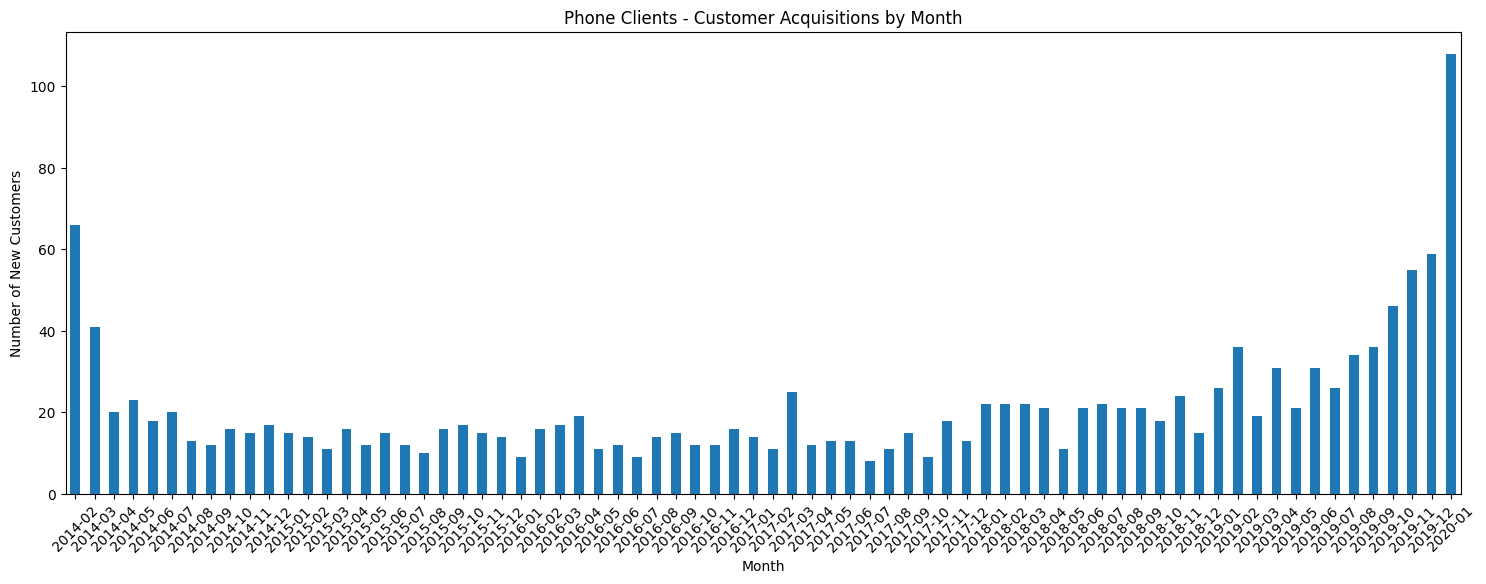

/tmp/ipykernel_2248/2107066663.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned['endmonth'] = churned['enddate'].dt.to_period('M')


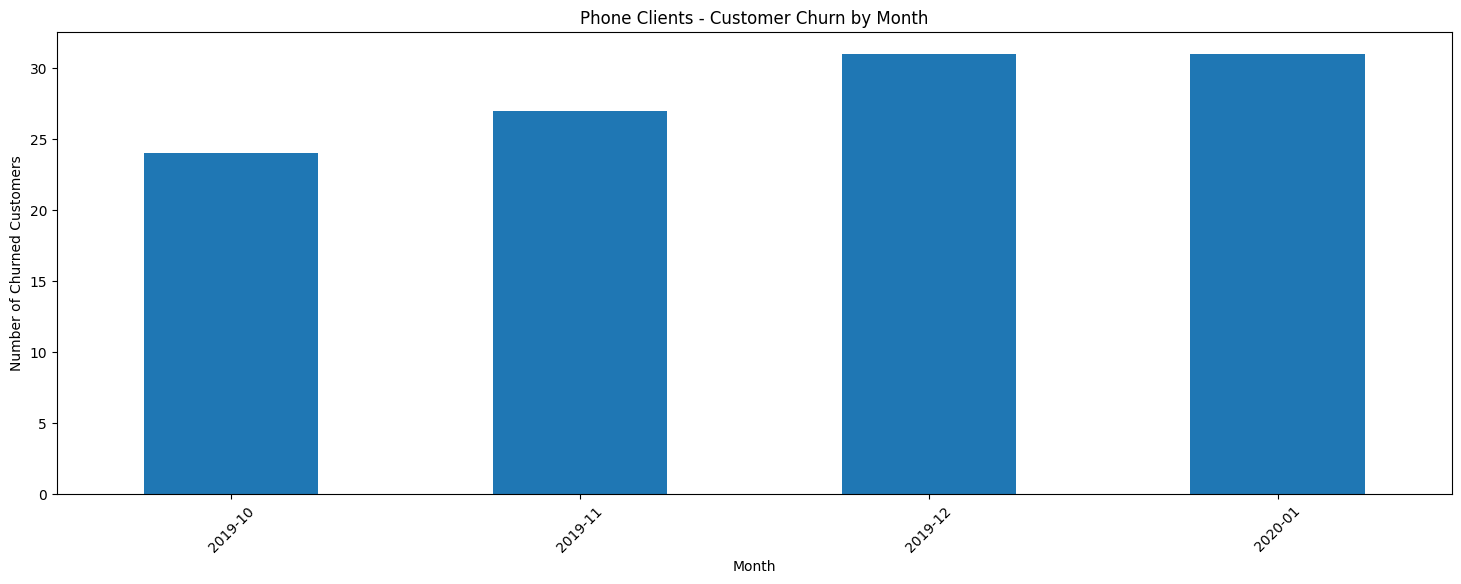

/tmp/ipykernel_2248/2107066663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beginmonth'] = df['begindate'].dt.to_period('M')


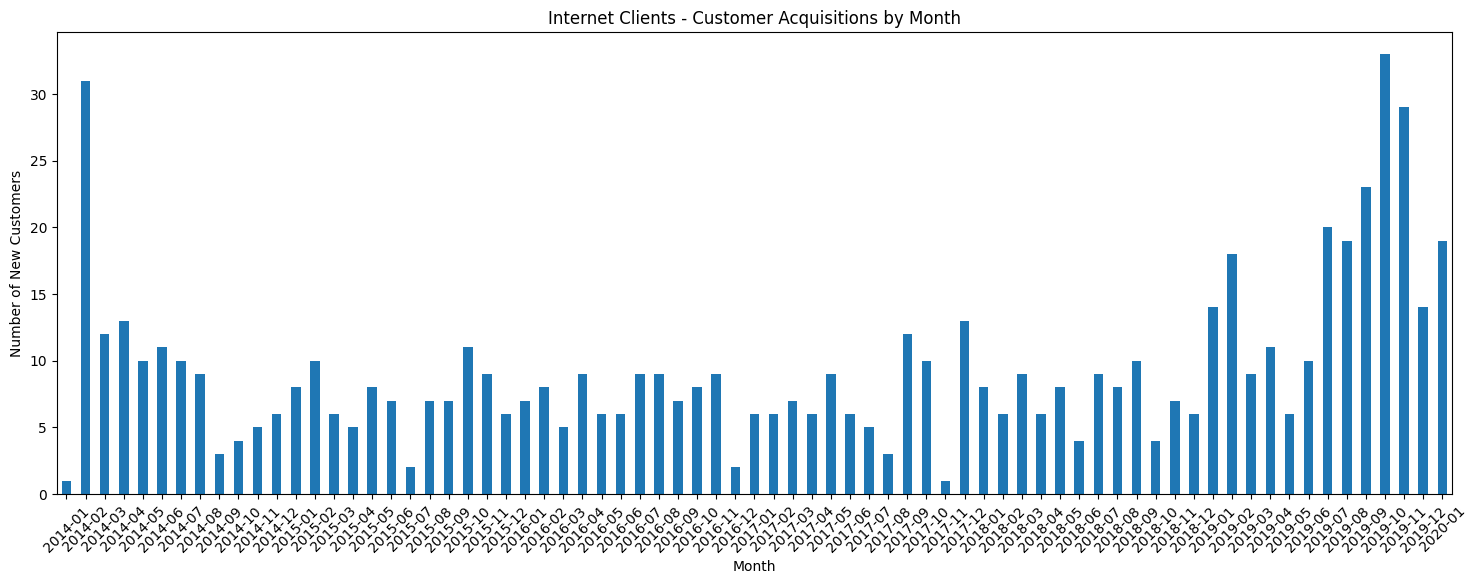

/tmp/ipykernel_2248/2107066663.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned['endmonth'] = churned['enddate'].dt.to_period('M')


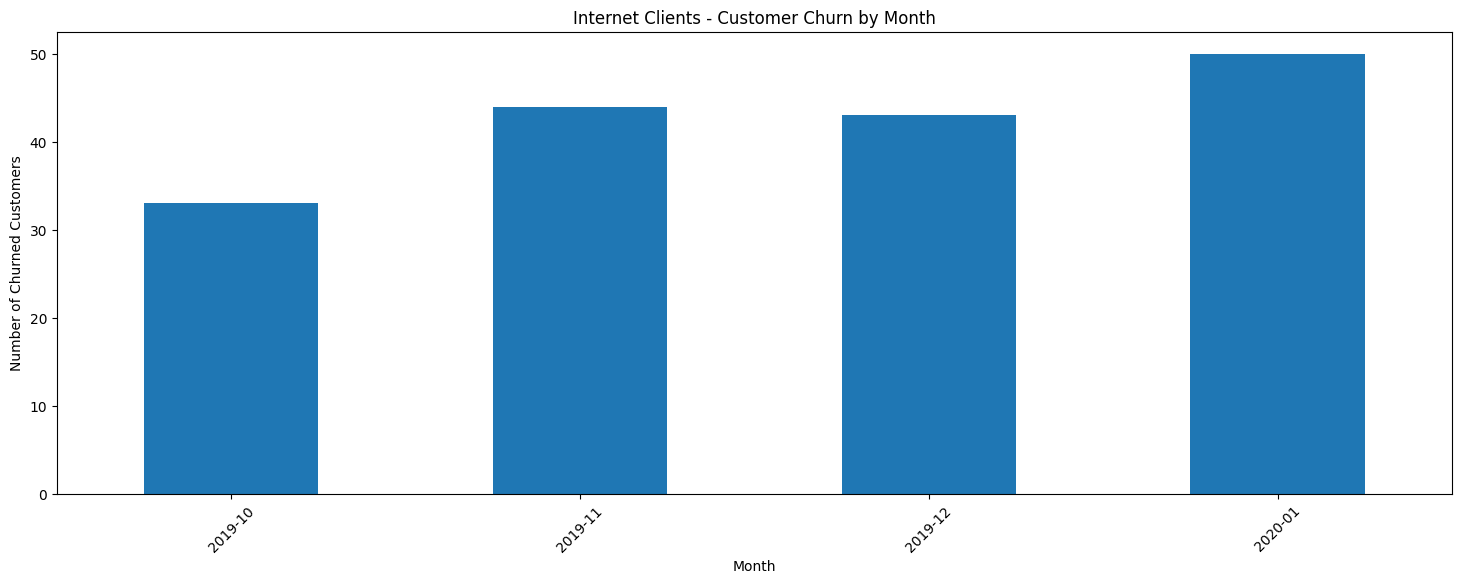

/tmp/ipykernel_2248/2107066663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beginmonth'] = df['begindate'].dt.to_period('M')


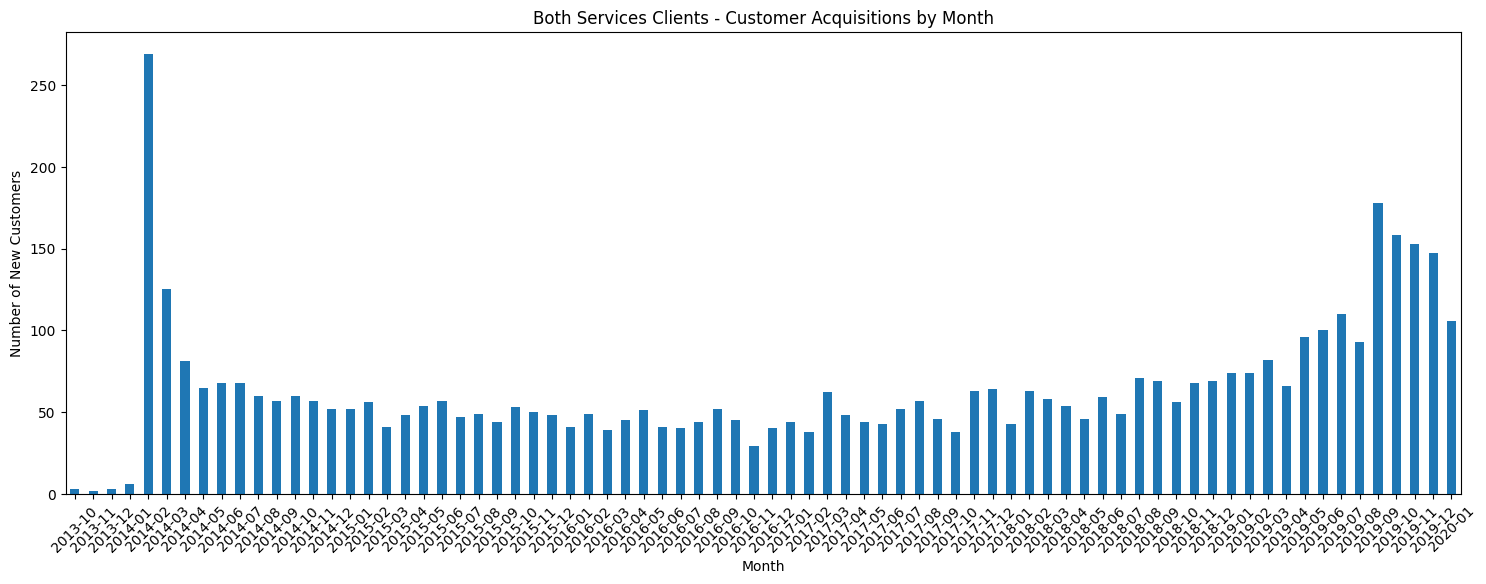

/tmp/ipykernel_2248/2107066663.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned['endmonth'] = churned['enddate'].dt.to_period('M')


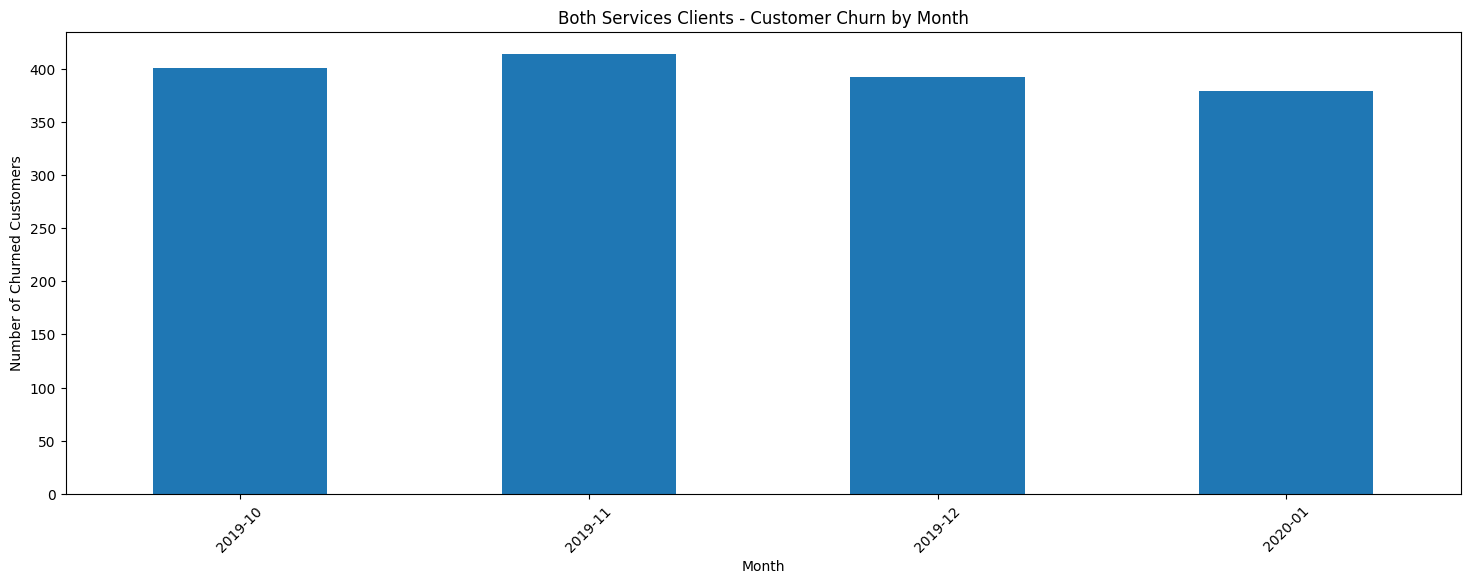

In [10]:
def plot_acquisition_and_churn(df, client_type):
    # Acquisition plot
    df['beginmonth'] = df['begindate'].dt.to_period('M')
    begin_counts = df['beginmonth'].value_counts().sort_index()
    
    plt.figure(figsize=(18, 6))
    begin_counts.plot(kind='bar', title=f'{client_type} - Customer Acquisitions by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of New Customers')
    plt.xticks(rotation=45)
    plt.show()
    
    # Churn plot
    churned = df[df['enddate'].notna()]
    churned['endmonth'] = churned['enddate'].dt.to_period('M')
    churn_counts = churned['endmonth'].value_counts().sort_index()
    
    plt.figure(figsize=(18, 6))
    churn_counts.plot(kind='bar', title=f'{client_type} - Customer Churn by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Churned Customers')
    plt.xticks(rotation=45)
    plt.show()

# Apply to all three client segments
plot_acquisition_and_churn(phone_client, 'Phone Clients')
plot_acquisition_and_churn(internet_client, 'Internet Clients')
plot_acquisition_and_churn(both_client, 'Both Services Clients')

It appears that January of 2014 saw a spike of customers entering contracts, then tapering off to a plateau before slowly rising from 2019 to 2020.  A slight sustained peak appeared in 2019 from August to the end of the year.  However, it appears that this period also saw many customers leave.  Let's investigate this timeframe more to see what was driving the churn, if longterm customers were leaving after their contract ran out or if new customers were canceling their contracts early.  It is interesting that all of the churn occurred within a sustained 4 month span, not scattered across months of a year or even years.

# Project Plan

**Performed**
1. Downloaded data, and joined separate CSVs into one dataframe.
2. Perfromed some preprocessing including changing data types to more useful types, changing date columns to date-time type. checking for duplicates and missing values.
3. Continued prelimenary EDA into data, splitting the dataframe into 3 distinct dataframes by service: phone_client, internet_client, both_client.
4. Visualized customer acquisition and churn dates.

**Next Steps**
1. Perfrom additional EDA on the 3 groups to determine best features relating to churn for each group.
3. Perfrom Time Series visualizations to determine seasonality for 'begindate' and 'enddate' columns'.  Why are the last 4 months of 2019 so churn-heavy?
4. Given that both_client contains the vast majority of active and churned customers, that group will be our focus.  internet_client also showed a comparatively similar proportion of churned to active customers, while phone_client showed the smallest proportion of churned to active customers.
5. Balancing the classes will probably require returning to the original joined DataFrame, "interconnect_df".
6. Create groups based on churned and active.
7. Once features have been selected, select model (probably boosting), and begin testing.

**Clarifying Questions**
1. How does contract type (month-month, one-year, two-year) affect churn?
2. Do personal features (gender, senior citizen status, partner, dependents) affect churn?
3. Do multiple phone lines or internet service type affect churn?
4. Of those customers who churned out at the end of 2019, how many were recent acquisitions, and how recently did they sign contracts of which type?
5. How many customers renewed their contracts, and what features retained their loyalty?

# Additional EDA

We will begin with additional EDA on phone_client, internet_client, and both_client to determine most relevant features for the model. Of particular interest are the contract types, personal demographic information, service type, and time from customer entry to exit (if customers who exit are long term customers or recent acquisitions). After some consideration of the previous graphs, time series seasonality visualizations do not appear to be relevant due to the spike of customer exits at the end of 2019.  If the data was more muddled or if spikes occurred during other years, investigating seasonality would be useful.

After determining most relevant features from the three dataframes, we will return to the original 'interconnect_df' dataframe before the splits to conduct class balancing, model preprocessing, and train-validation-test splits.

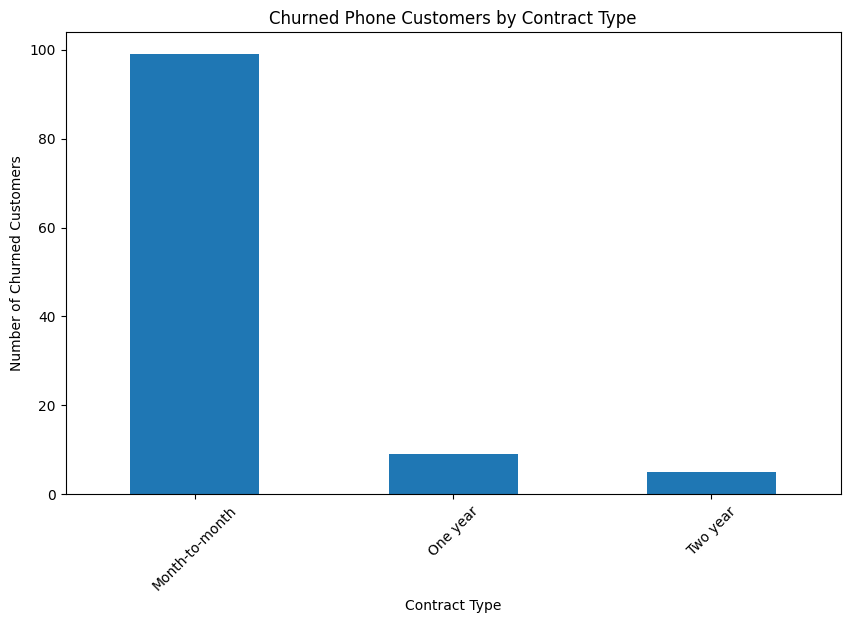

In [11]:
#phone_client graph: contract types vs churn
phone_churned = phone_client[phone_client['enddate'].notna()]

plt.figure(figsize=(10, 6))
phone_churned['type'].value_counts().plot(kind='bar', title='Churned Phone Customers by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

Month-to-Month contracts were by far the most canceled.  It appears that the longer contracts cancel less than shorter contracts.  Judging by this graph, I predict internet_client and both client will show the similar results.

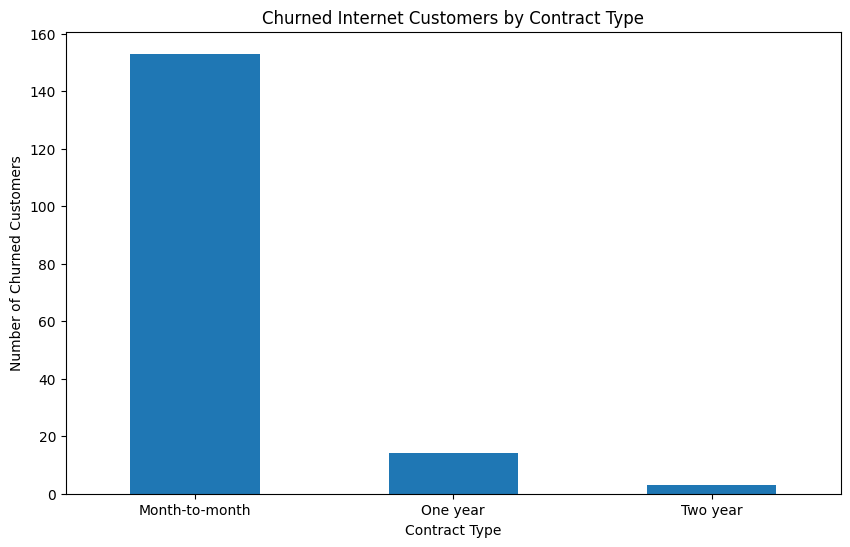

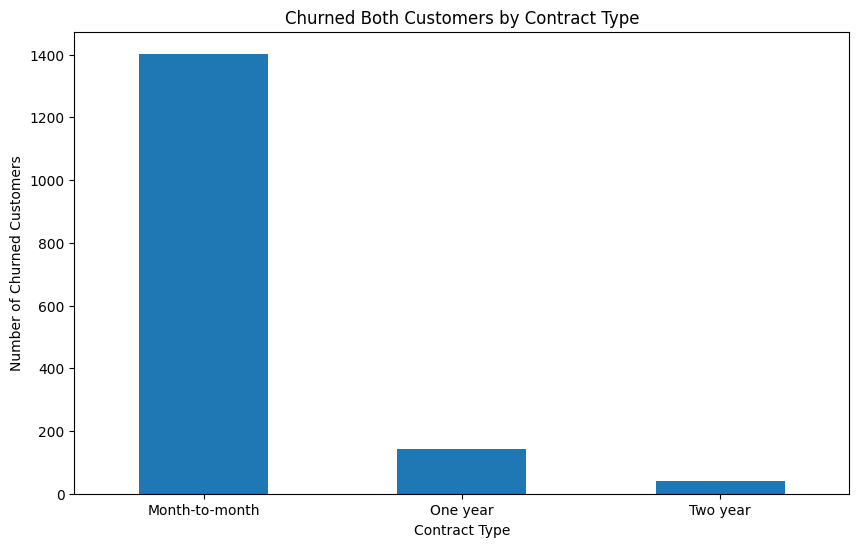

In [12]:
#internet_client: contract types vs churn
internet_churned = internet_client[internet_client['enddate'].notna()]

plt.figure(figsize=(10, 6))
internet_churned['type'].value_counts().plot(kind='bar', title='Churned Internet Customers by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

#both_client graph: contract types vs churn
both_churned = both_client[both_client['enddate'].notna()]

plt.figure(figsize=(10, 6))
both_churned['type'].value_counts().plot(kind='bar', title='Churned Both Customers by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

My prediction was correct.  'internet_client' and 'both_client' datasets show the same trend of month-to-month customers canceling their contracts in far greater numbers than one-year and two-year customers.  Contract 'type' is an important feature to include in model training. 

Let's investigate personal demographics for each dataframe.

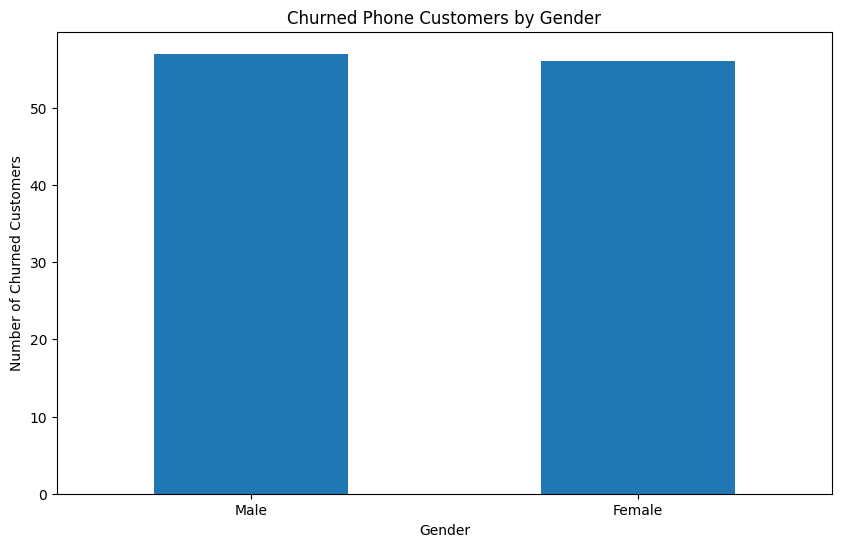

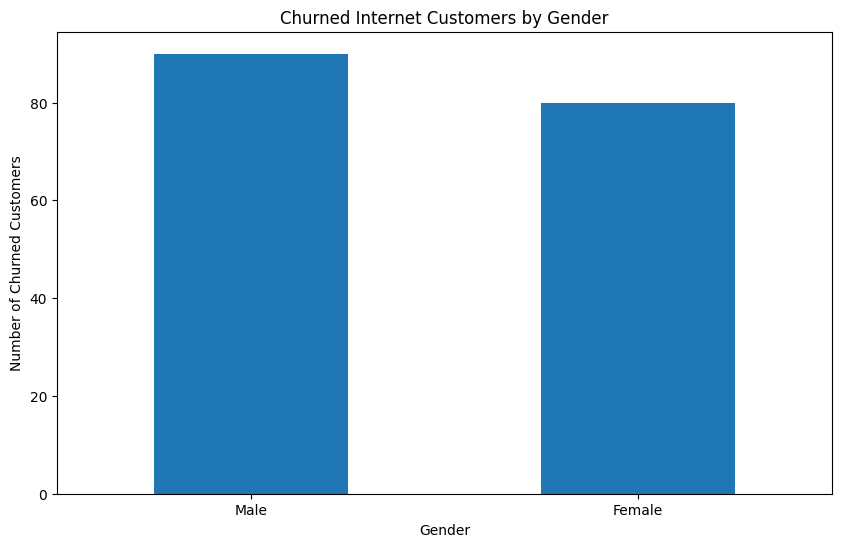

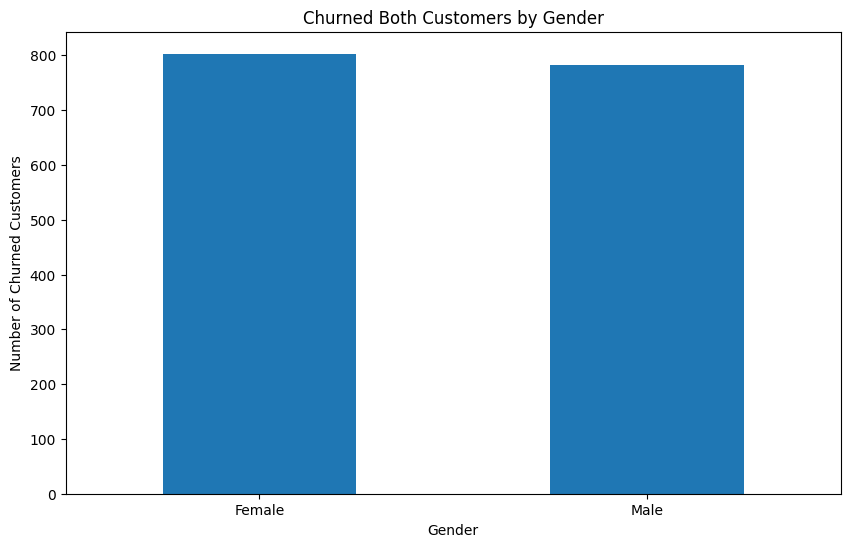

In [13]:
#phone_client personal demographics: gender vs churn
plt.figure(figsize=(10, 6))
phone_churned['gender'].value_counts().plot(kind='bar', title='Churned Phone Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

#internet_client personal demographics: gender vs churn
plt.figure(figsize=(10, 6))
internet_churned['gender'].value_counts().plot(kind='bar', title='Churned Internet Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

#both_client personal demographics: gender vs churn
plt.figure(figsize=(10, 6))
both_churned['gender'].value_counts().plot(kind='bar', title='Churned Both Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

It appears that gender does not play a significant role in customer churn.  Roughly equal amounts of male and female customers churned out.  Male internet only customers churned out at a slightly hire rate than female internet only customers.

Let's investigate Senior Citizen Status.

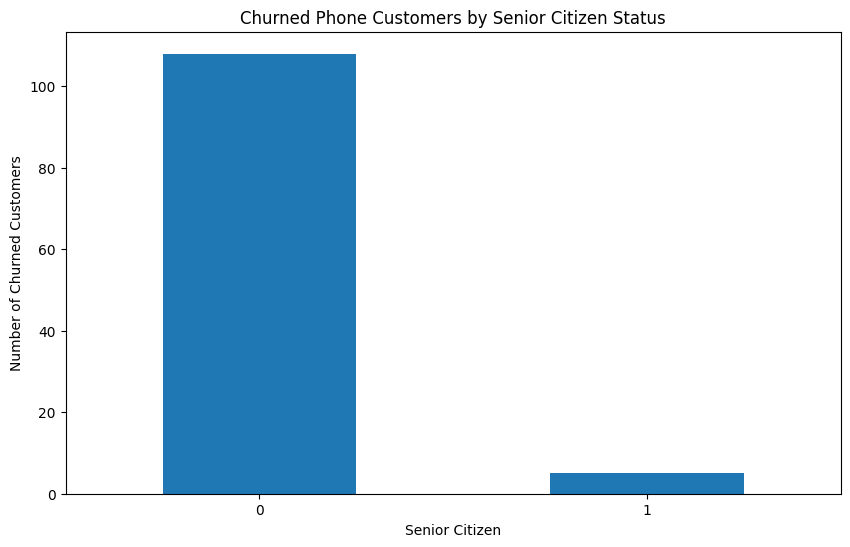

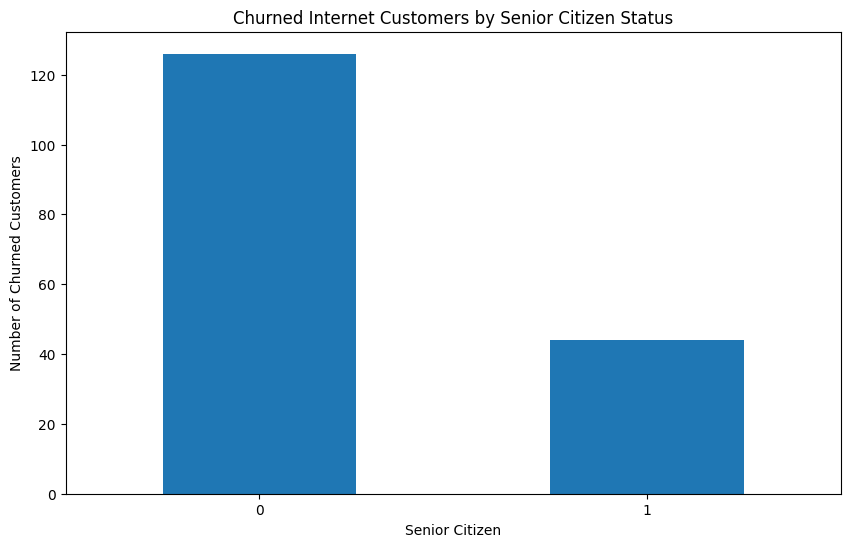

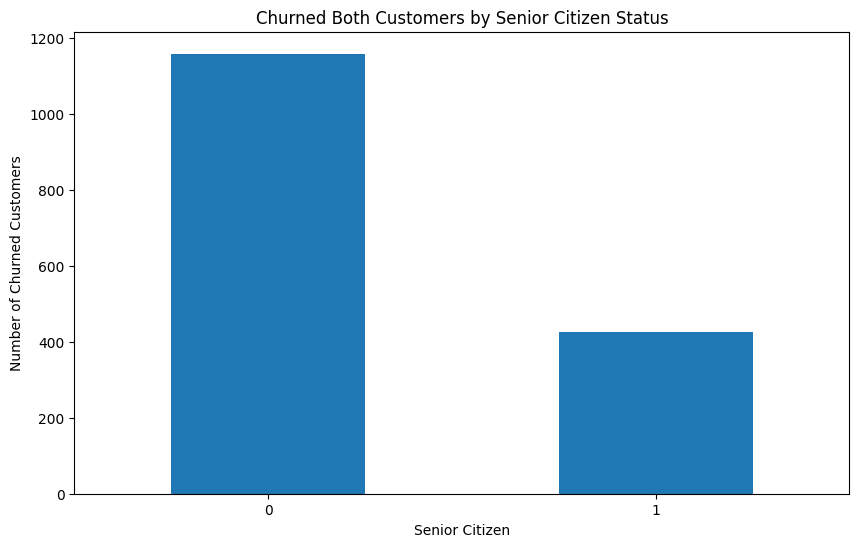

In [14]:
#phone_client personal demographics: senior citizen vs churn
plt.figure(figsize=(10, 6))
phone_churned['seniorcitizen'].value_counts().plot(kind='bar', title='Churned Phone Customers by Senior Citizen Status')
plt.xlabel('Senior Citizen')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

#internet_client personal demographics: gender vs churn
plt.figure(figsize=(10, 6))
internet_churned['seniorcitizen'].value_counts().plot(kind='bar', title='Churned Internet Customers by Senior Citizen Status')
plt.xlabel('Senior Citizen')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

#both_client personal demographics: gender vs churn
plt.figure(figsize=(10, 6))
both_churned['seniorcitizen'].value_counts().plot(kind='bar', title='Churned Both Customers by Senior Citizen Status')
plt.xlabel('Senior Citizen')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=0)
plt.show()

It appears that customers who were not senior citizens canceled their plans in much higher numbers than senior citizens did.  In fact, it appears that senior citizens who subscribed to only phone services had the lowest number of cancellations across all three groups.  Senior Citizen is an important feature in model training.

Let's investigate partner status.

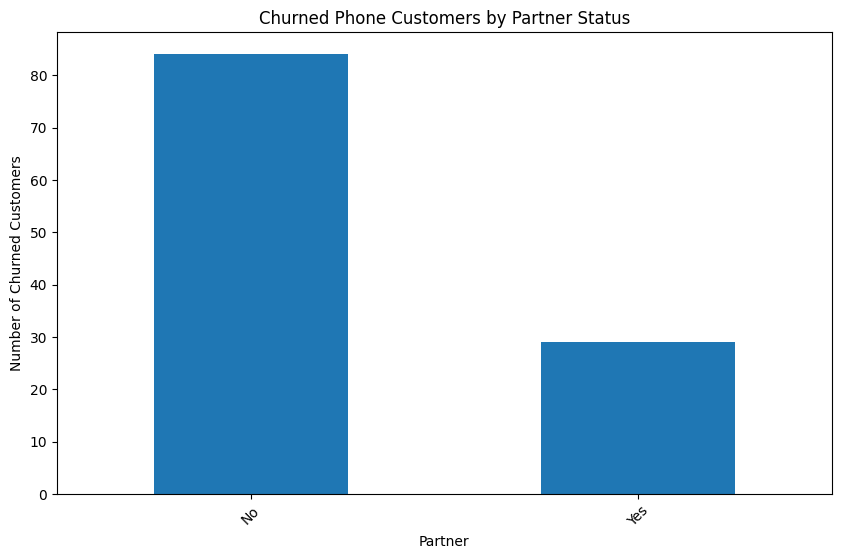

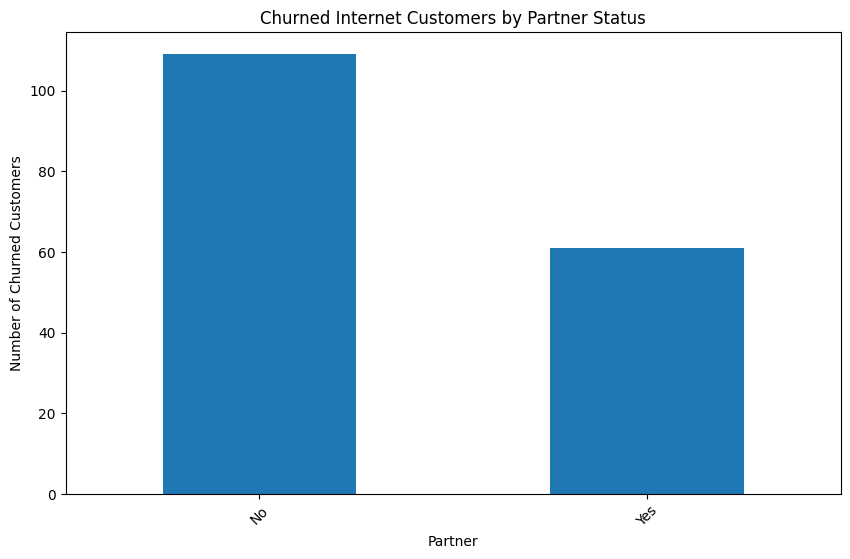

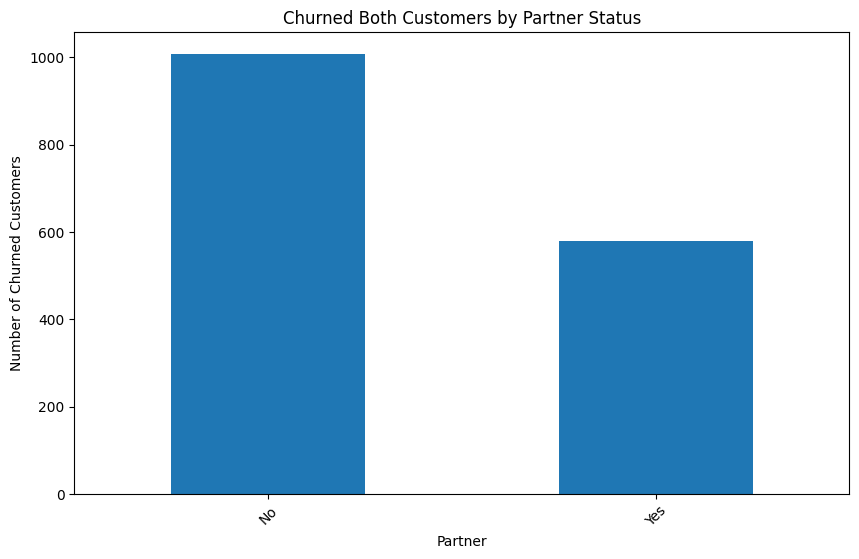

In [15]:
#phone_client personal demographics: partner vs churn
plt.figure(figsize=(10, 6))
phone_churned['partner'].value_counts().plot(kind='bar', title='Churned Phone Customers by Partner Status')
plt.xlabel('Partner')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#internet_client personal demographics: partner vs churn
plt.figure(figsize=(10, 6))
internet_churned['partner'].value_counts().plot(kind='bar', title='Churned Internet Customers by Partner Status')
plt.xlabel('Partner')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client personal demographics: partner vs churn
plt.figure(figsize=(10, 6))
both_churned['partner'].value_counts().plot(kind='bar', title='Churned Both Customers by Partner Status')
plt.xlabel('Partner')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

It appears that customers who do not have partners canceled their contracts in much higher numbers than customers with partners.  Partner status is an important feature for model training.

Let's move on to dependent status.

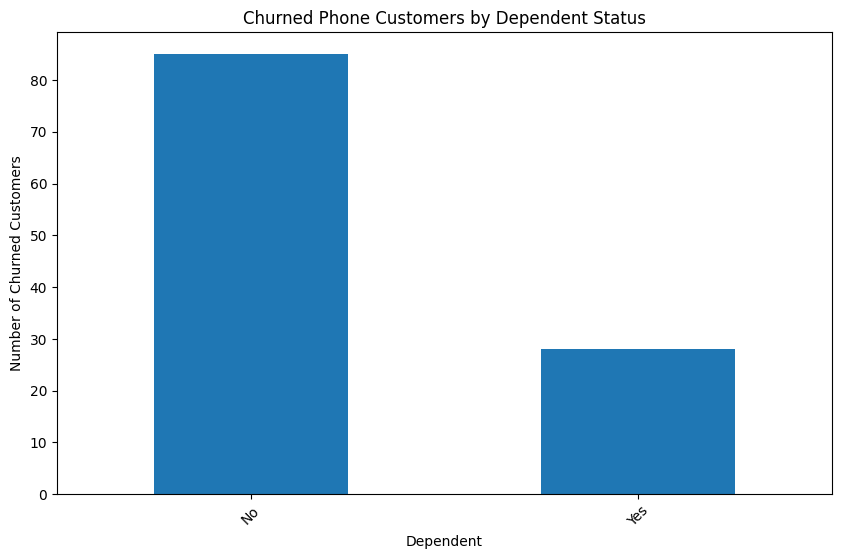

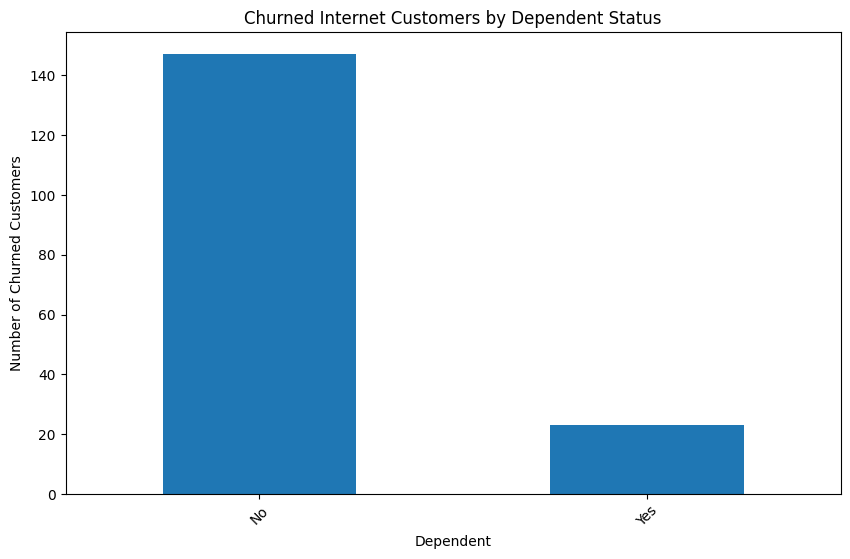

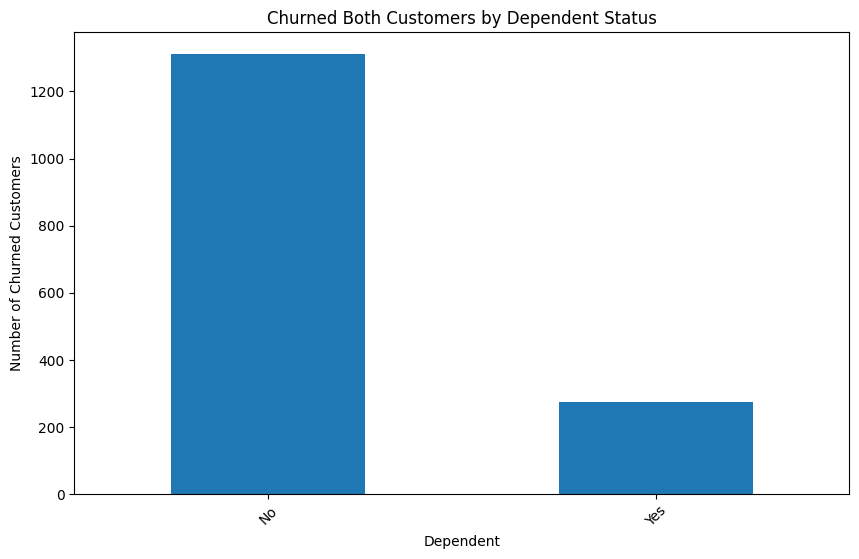

In [16]:
#phone_client personal demographics: dependent vs churn
plt.figure(figsize=(10, 6))
phone_churned['dependents'].value_counts().plot(kind='bar', title='Churned Phone Customers by Dependent Status')
plt.xlabel('Dependent')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#internet_client personal demographics: dependet vs churn
plt.figure(figsize=(10, 6))
internet_churned['dependents'].value_counts().plot(kind='bar', title='Churned Internet Customers by Dependent Status')
plt.xlabel('Dependent')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client personal demographics: dependent vs churn
plt.figure(figsize=(10, 6))
both_churned['dependents'].value_counts().plot(kind='bar', title='Churned Both Customers by Dependent Status')
plt.xlabel('Dependent')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

Similar results to partner status, but with greater disparity.  Customers who do not have depenedents cancel their contracts in much higher numbers than customers who do have dependents.  Dependent status is an important feature for model training.

Let's investigate 'internet_client' and 'both_client' in respect to their internet features.

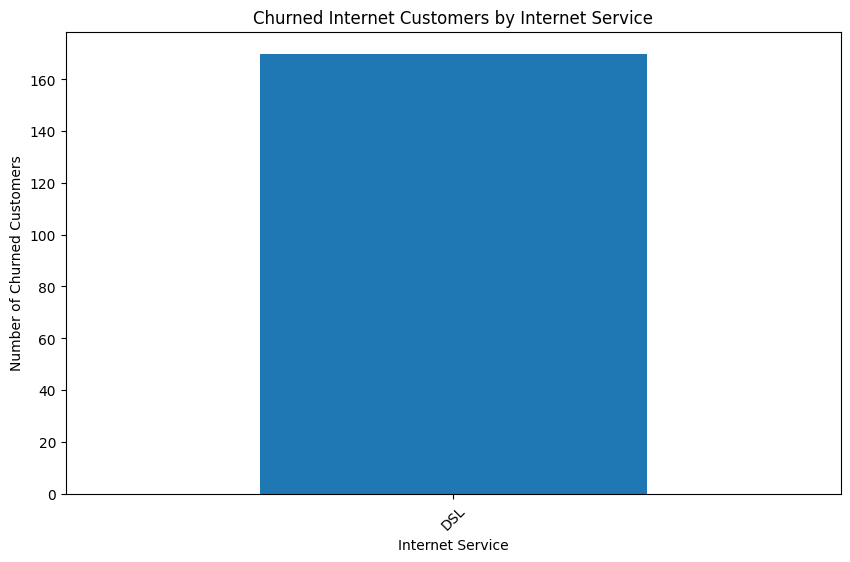

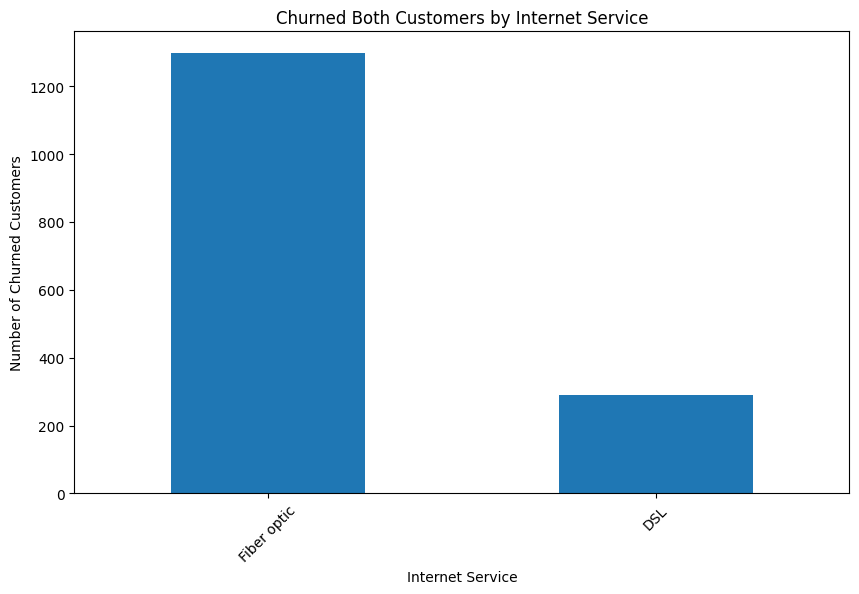

In [17]:
#internet_client: internetservice vs churn
plt.figure(figsize=(10, 6))
internet_churned['internetservice'].value_counts().plot(kind='bar', title='Churned Internet Customers by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client: internetservice vs churn
plt.figure(figsize=(10, 6))
both_churned['internetservice'].value_counts().plot(kind='bar', title='Churned Both Customers by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

Interestingly, in 'internet_client' every customer that churned had DSL service.  Conversely, for customers that held both phone and internet plans, customers that had  fiber optic internet service canceled in higher amounts than DSL customers.  Perhaps the high price point of fiber optic was an exiting factor.  Due to sheer numbers of fiber optic cancellations compared to DSL cancellations, fiberoptic service is the more important feature for model training.

Let's move on to online security.

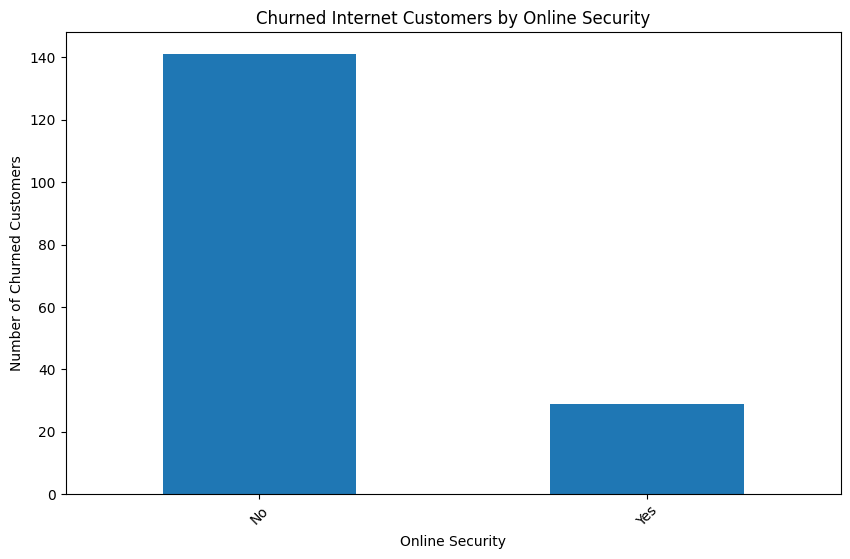

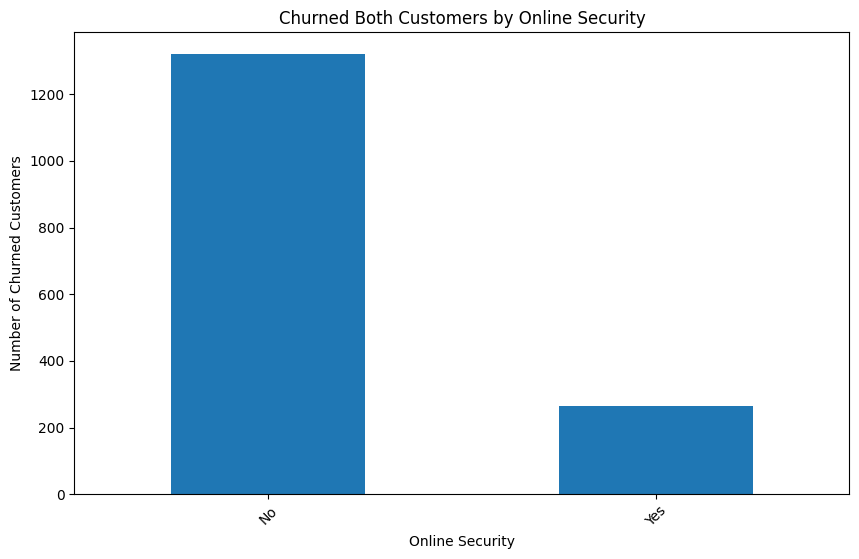

In [18]:
#internet_client: online security vs churn
plt.figure(figsize=(10, 6))
internet_churned['onlinesecurity'].value_counts().plot(kind='bar', title='Churned Internet Customers by Online Security')
plt.xlabel('Online Security')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client: online security vs churn
plt.figure(figsize=(10, 6))
both_churned['onlinesecurity'].value_counts().plot(kind='bar', title='Churned Both Customers by Online Security')
plt.xlabel('Online Security')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

Customers that did not subscribe to online security services canceled their contracts in much higher numbers than customers who did subscribe.  Online security status is an important feature for model training.

Let's move on to online backup.

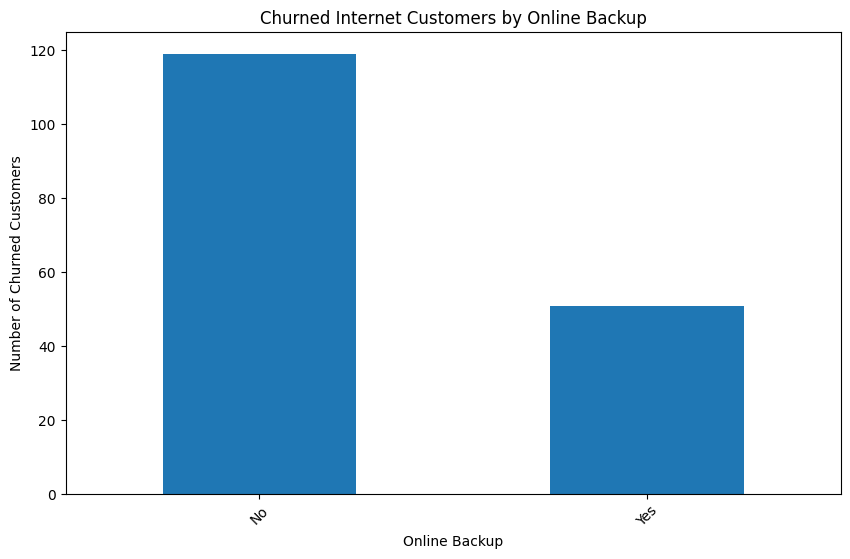

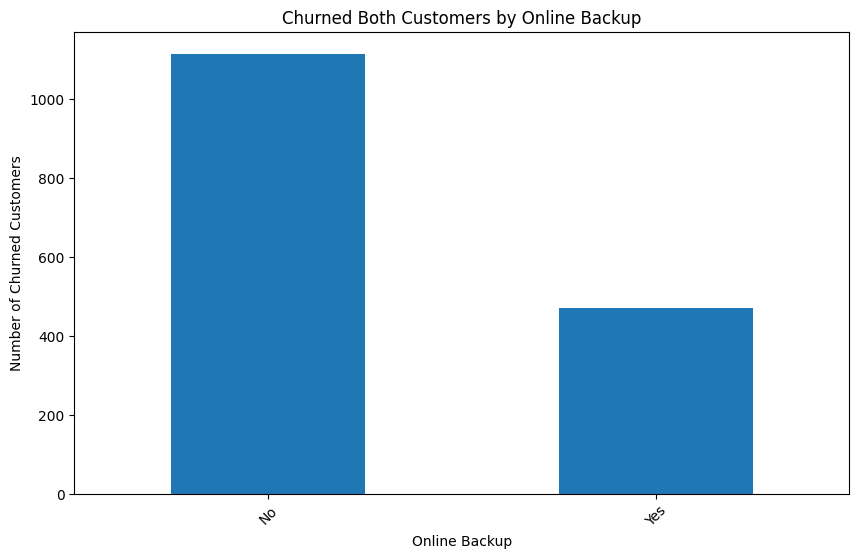

In [19]:
#internet_client: online backup vs churn
plt.figure(figsize=(10, 6))
internet_churned['onlinebackup'].value_counts().plot(kind='bar', title='Churned Internet Customers by Online Backup')
plt.xlabel('Online Backup')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client: online backup vs churn
plt.figure(figsize=(10, 6))
both_churned['onlinebackup'].value_counts().plot(kind='bar', title='Churned Both Customers by Online Backup')
plt.xlabel('Online Backup')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

Similarly to online security, customers that did not subscribe to online backup canceled their contracts more than customers that did subscribe.  Online backup is an important feature for model training.

Let's move on to device protection.

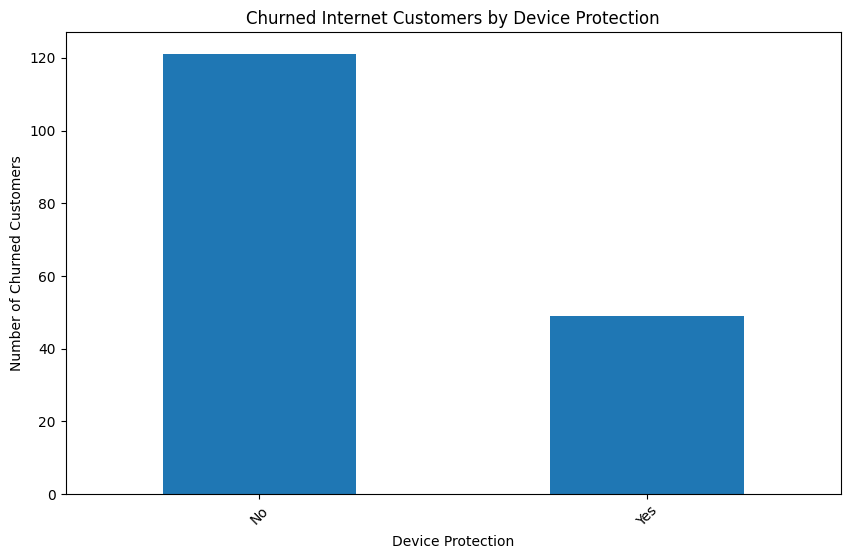

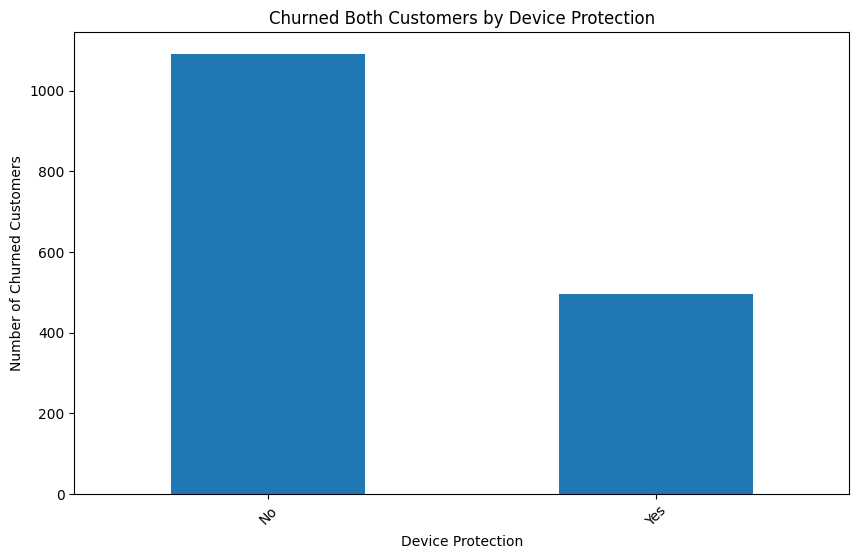

In [20]:
#internet_client: device protection vs churn
plt.figure(figsize=(10, 6))
internet_churned['deviceprotection'].value_counts().plot(kind='bar', title='Churned Internet Customers by Device Protection')
plt.xlabel('Device Protection')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client: device protection vs churn
plt.figure(figsize=(10, 6))
both_churned['deviceprotection'].value_counts().plot(kind='bar', title='Churned Both Customers by Device Protection')
plt.xlabel('Device Protection')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

The trend continues with device protection.  Customers that did not subscribe to device protection canceled their contracts more than customers than did.  Device protection is an important feature for model training.

Let's move on to tech support.

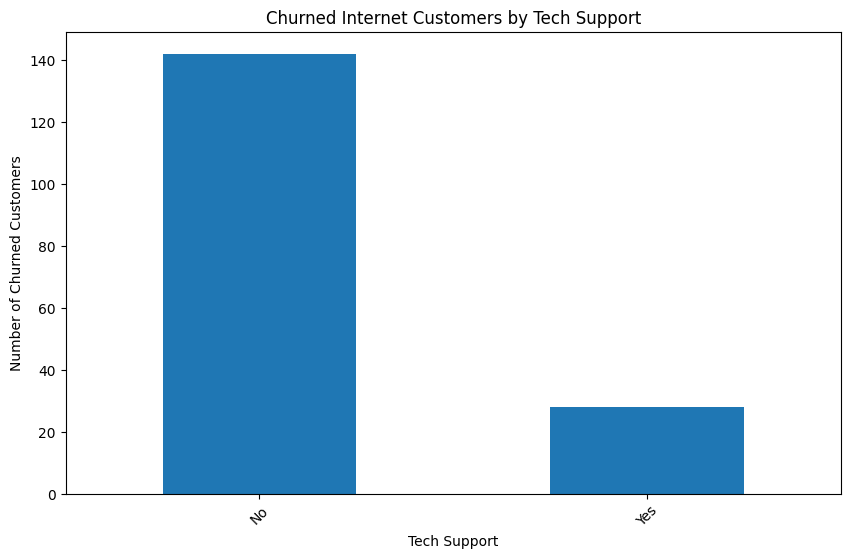

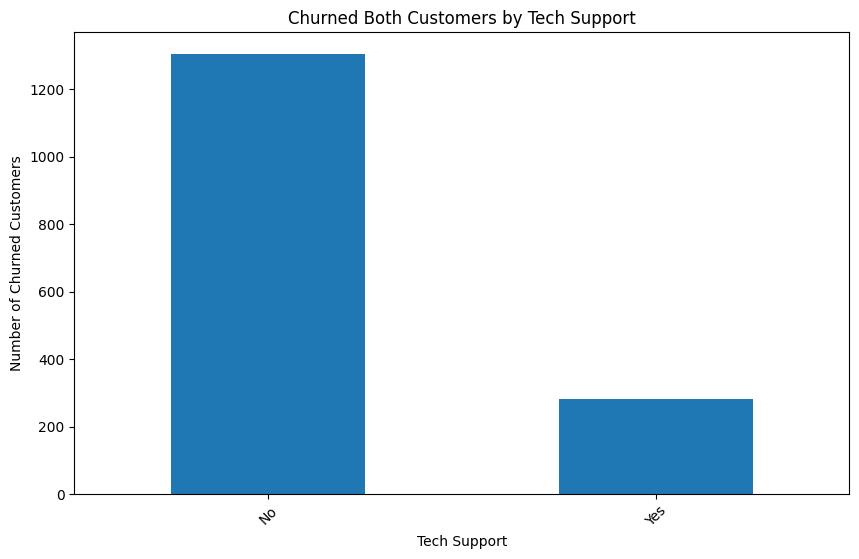

In [21]:
#internet_client: tech support vs churn
plt.figure(figsize=(10, 6))
internet_churned['techsupport'].value_counts().plot(kind='bar', title='Churned Internet Customers by Tech Support')
plt.xlabel('Tech Support')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client: tech support vs churn
plt.figure(figsize=(10, 6))
both_churned['techsupport'].value_counts().plot(kind='bar', title='Churned Both Customers by Tech Support')
plt.xlabel('Tech Support')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

The trend continues to persist.  Customers that did not subscribe to tech support canceled their contracts more than customers that did subscribe.  Tech support is an important feature for model training.

Let's move on to streaming services: tv and movies.

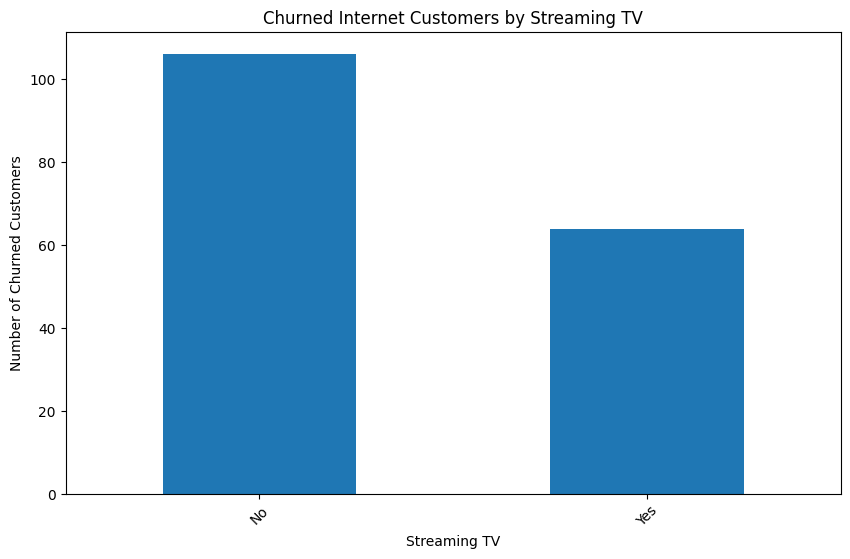

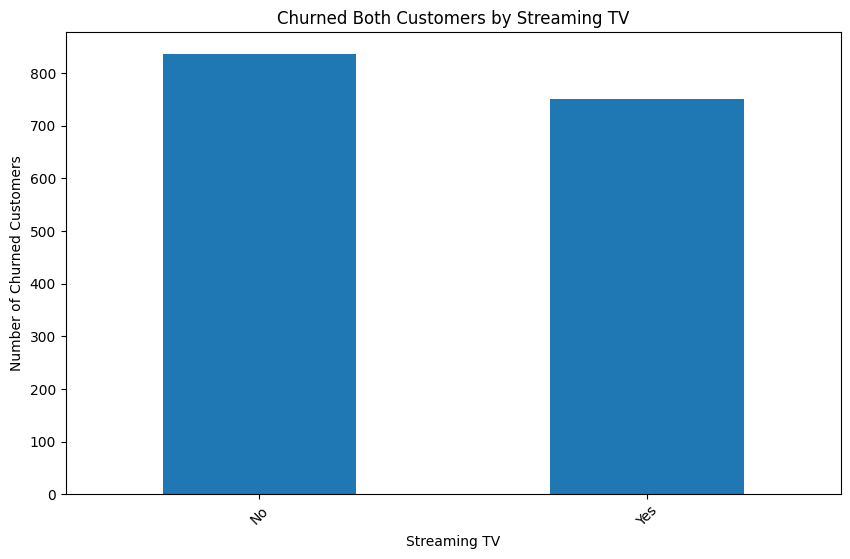

In [22]:
#internet_client: streaming tv vs churn
plt.figure(figsize=(10, 6))
internet_churned['streamingtv'].value_counts().plot(kind='bar', title='Churned Internet Customers by Streaming TV')
plt.xlabel('Streaming TV')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client: streaming tv vs churn
plt.figure(figsize=(10, 6))
both_churned['streamingtv'].value_counts().plot(kind='bar', title='Churned Both Customers by Streaming TV')
plt.xlabel('Streaming TV')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

While streaming tv services had more of an impact for customers that had internet-only plans, roughly equal amounts of customers in 'both_client' churned regardless of streaming tv subscription.  For this reason, steraming tv is not an important feature.  Perhaps we will include it during model tuning to increase the accuracy of the model.

Let's move on to streaming movies.

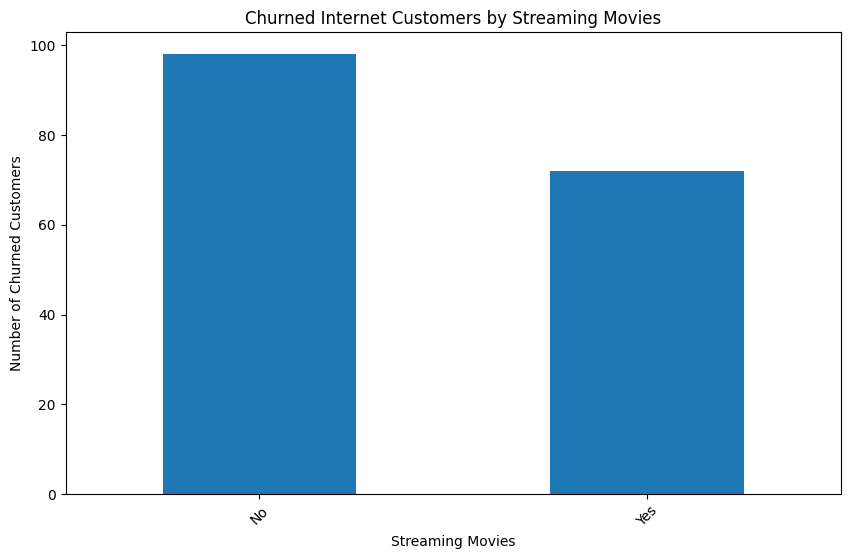

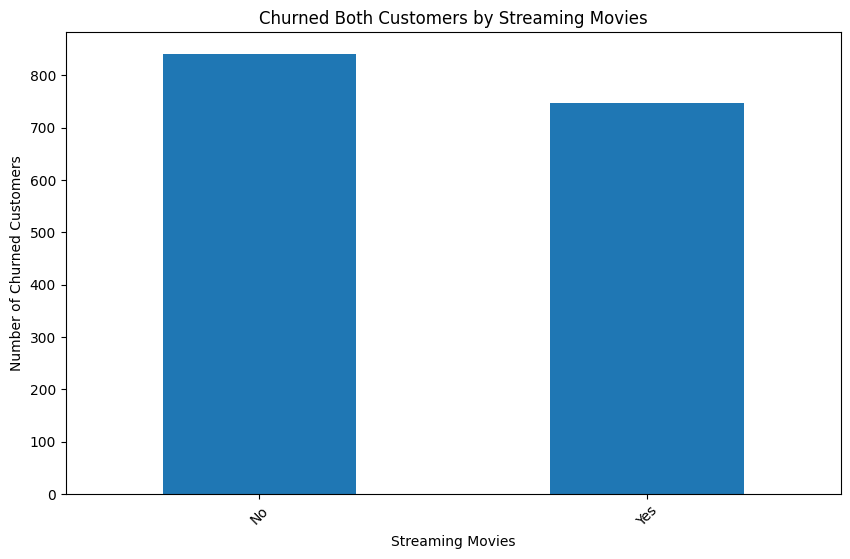

In [23]:
#internet_client: streaming movies vs churn
plt.figure(figsize=(10, 6))
internet_churned['streamingmovies'].value_counts().plot(kind='bar', title='Churned Internet Customers by Streaming Movies')
plt.xlabel('Streaming Movies')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

#both_client: streaming movies vs churn
plt.figure(figsize=(10, 6))
both_churned['streamingmovies'].value_counts().plot(kind='bar', title='Churned Both Customers by Streaming Movies')
plt.xlabel('Streaming Movies')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

Similar to streaming tv customers, streaming tv had more of an impact for customers that had internet-only plans, while roughly equal amounts of customers in 'both_client' churned regardless of streaming tv subscription.  For this reason, steraming movies is not an important feature.  Perhaps we will include it during model tuning to increase the accuracy of the model.

Let's move on to our final feature, monthly charges.

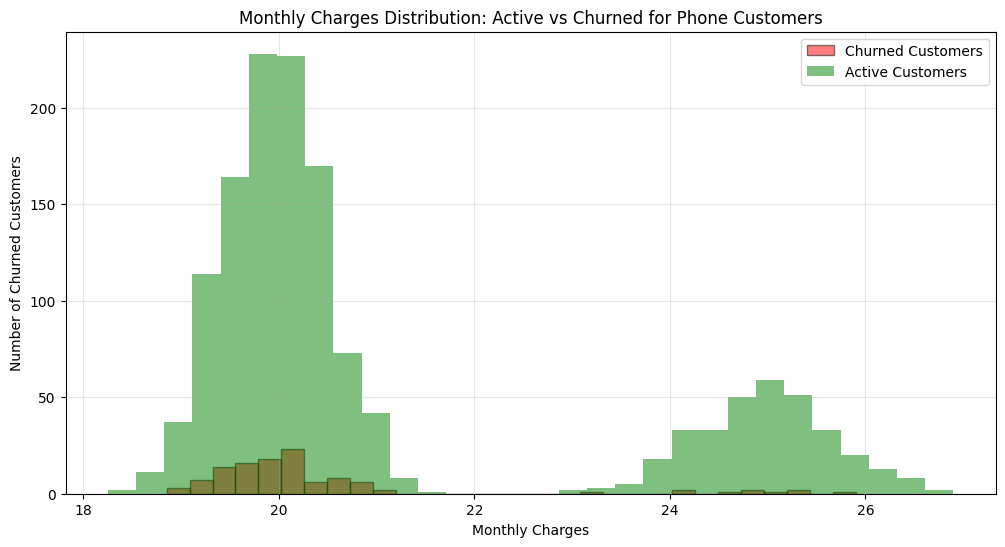

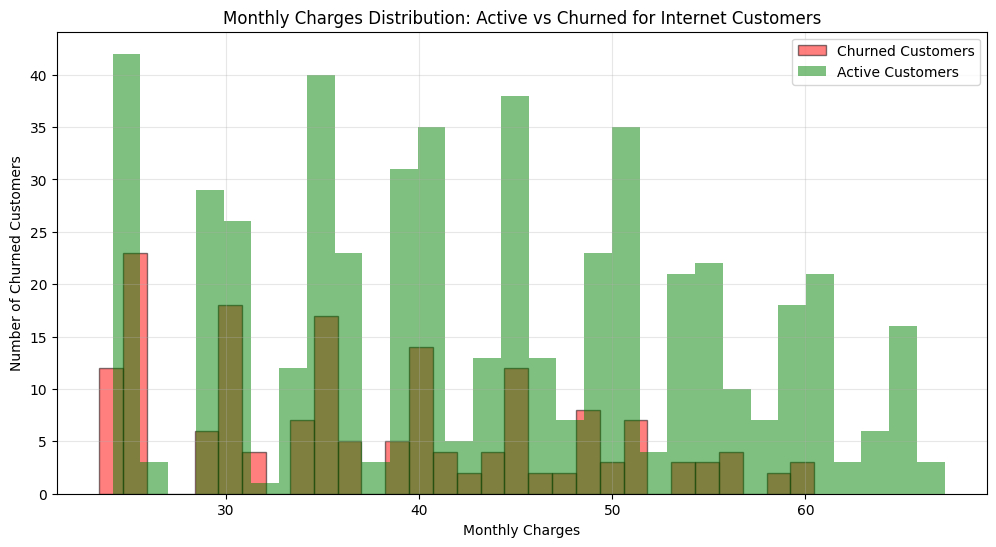

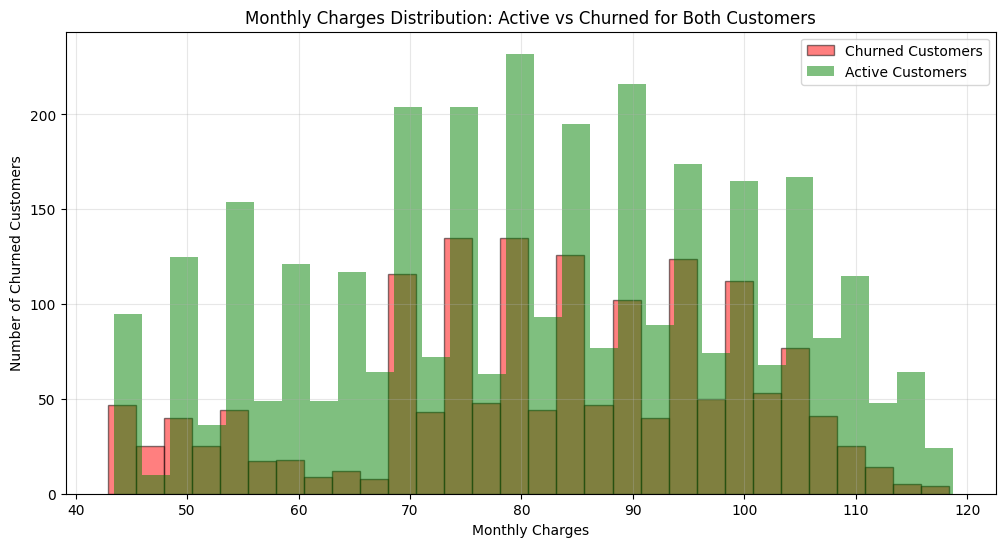

In [24]:
#phone_client: monthly charges and churn
phone_active = phone_client[phone_client['enddate'].isna()]

plt.figure(figsize=(12, 6))
plt.hist(phone_churned['monthlycharges'], bins=30, alpha=0.5, label='Churned Customers', color='red', edgecolor='black')
plt.hist(phone_active['monthlycharges'], bins=30, alpha=0.5, label='Active Customers', color='green')
plt.title('Monthly Charges Distribution: Active vs Churned for Phone Customers')
plt.xlabel('Monthly Charges')
plt.ylabel('Number of Churned Customers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#internet_client monthly charges and churn
internet_active = internet_client[internet_client['enddate'].isna()]

plt.figure(figsize=(12, 6))
plt.hist(internet_churned['monthlycharges'], bins=30, alpha=0.5, label='Churned Customers', color='red', edgecolor='black')
plt.hist(internet_active['monthlycharges'], bins=30, alpha=0.5, label='Active Customers', color='green')
plt.title('Monthly Charges Distribution: Active vs Churned for Internet Customers')
plt.xlabel('Monthly Charges')
plt.ylabel('Number of Churned Customers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#both_client personal demographics: dependent vs churn
both_active = both_client[both_client['enddate'].isna()]

plt.figure(figsize=(12, 6))
plt.hist(both_churned['monthlycharges'], bins=30, alpha=0.5, label='Churned Customers', color='red', edgecolor='black')
plt.hist(both_active['monthlycharges'], bins=30, alpha=0.5, label='Active Customers', color='green')
plt.title('Monthly Charges Distribution: Active vs Churned for Both Customers')
plt.xlabel('Monthly Charges')
plt.ylabel('Number of Churned Customers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


It appears that monthly price does not impact churn significantly.  The graphs show churned and active customers sharing the same distributions in monthly price with little deviation.  Montly price is not an important feature for model training.

Our important features are: 
1. type (month-to-month)
2. senior citizen (no)
3. partner (no)
4. dependents (no)
5. internet service (fiber optic)
6. online security (no)
7. online backup (no)
8. device protection (no)
9. tech support (no)

No we can return to our original dataframe before splitting customers, investigate class balance, and split our dataset into training, validation, and test.

# Core Solution Code

In [25]:
#filling missing values in 'enddate' to make binary classification easier
interconnect_df['enddate'] = interconnect_df['enddate'].fillna('No')
interconnect_df['enddate'].isna().sum()

0

In [26]:
#creating target
interconnect_df['churn'] = (interconnect_df['enddate'] != 'No').astype(int)

print('Sample of target variable:')
print(interconnect_df[['enddate', 'churn']].head(10))

Sample of target variable:
               enddate  churn
0                   No      0
1                   No      0
2  2019-12-01 00:00:00      1
3                   No      0
4  2019-11-01 00:00:00      1
5  2019-11-01 00:00:00      1
6                   No      0
7                   No      0
8  2019-11-01 00:00:00      1
9                   No      0


In [27]:
#showing class distribution
churn_counts = interconnect_df['churn'].value_counts()
churn_percent = interconnect_df['churn'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"Active customers (0): {churn_counts[0]} ({churn_percent[0]:.2f}%)")
print(f"Churned customers (1): {churn_counts[1]} ({churn_percent[1]:.2f}%)")

Class Distribution:
Active customers (0): 5163 (73.42%)
Churned customers (1): 1869 (26.58%)


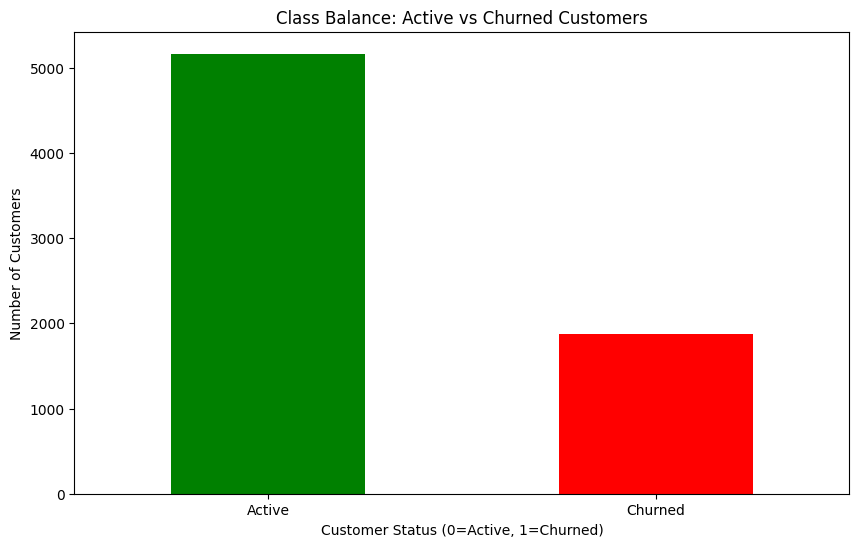

In [28]:
#class balance visualization
plt.figure(figsize=(10, 6))
churn_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Class Balance: Active vs Churned Customers')
plt.xlabel('Customer Status (0=Active, 1=Churned)')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Active', 'Churned'], rotation=0)
plt.show()

There appears to be a large class imbalance between active and churned customers.  When we get to training the model, we will need to adjust the class weights to ensure proper balancing.

In [29]:
#train-test-split on interconnect_df

features = interconnect_df.drop('churn', axis=1)
features = features.drop('customerid', axis=1)
target = interconnect_df['churn']

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42, stratify=target_temp)


In [30]:
#encoding features
for col in ['type', 'seniorcitizen', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport']:
    print(f"{col}: {interconnect_df[col].unique()}")

type: ['Month-to-month' 'One year' 'Two year']
seniorcitizen: [0 1]
partner: ['Yes' 'No']
dependents: ['No' 'Yes']
internetservice: ['DSL' 'Fiber optic' nan]
onlinesecurity: ['No' 'Yes' nan]
onlinebackup: ['Yes' 'No' nan]
deviceprotection: ['No' 'Yes' nan]
techsupport: ['No' 'Yes' nan]


In [31]:
interconnect_df.isna().sum()

customerid             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
multiplelines        680
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice     1520
onlinesecurity      1520
onlinebackup        1520
deviceprotection    1520
techsupport         1520
streamingtv         1520
streamingmovies     1520
churn                  0
dtype: int64

In [32]:
#function to fill missing values for encoding
columns_to_fill = ['multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
fill_string = 'Not in contract'

def fill_missing_service(interconnect_df, columns_to_fill, fill_string):
    filled_interconnect = interconnect_df.copy()
    filled_interconnect[columns_to_fill] = filled_interconnect[columns_to_fill].fillna(fill_string)
    return filled_interconnect

In [33]:
#testing function
new_interconnect = fill_missing_service(interconnect_df, columns_to_fill, fill_string)

print("Missing values before:", interconnect_df[columns_to_fill].isnull().sum().sum())
print("Missing values after:", new_interconnect[columns_to_fill].isnull().sum().sum())

Missing values before: 11320
Missing values after: 0


In [34]:
#label encoding
categorical_columns = ['type', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport']
encoded_interconnect = new_interconnect.copy()
# Apply label encoding
label_encoders = {}
for column in categorical_columns:
    if column != 'churn':
        le = LabelEncoder()
        encoded_interconnect[column] = le.fit_transform(encoded_interconnect[column])
        label_encoders[column] = le

        print(f"Encoded {column}: {le.classes_}")

print("Before encoding:")
print(new_interconnect[categorical_columns].head())

print("\nAfter encoding:")
print(encoded_interconnect[categorical_columns].head())

Encoded type: ['Month-to-month' 'One year' 'Two year']
Encoded partner: ['No' 'Yes']
Encoded dependents: ['No' 'Yes']
Encoded internetservice: ['DSL' 'Fiber optic' 'Not in contract']
Encoded onlinesecurity: ['No' 'Not in contract' 'Yes']
Encoded onlinebackup: ['No' 'Not in contract' 'Yes']
Encoded deviceprotection: ['No' 'Not in contract' 'Yes']
Encoded techsupport: ['No' 'Not in contract' 'Yes']
Before encoding:
             type partner dependents internetservice onlinesecurity  \
0  Month-to-month     Yes         No             DSL             No   
1        One year      No         No             DSL            Yes   
2  Month-to-month      No         No             DSL            Yes   
3        One year      No         No             DSL            Yes   
4  Month-to-month      No         No     Fiber optic             No   

  onlinebackup deviceprotection techsupport  
0          Yes               No          No  
1           No              Yes          No  
2          Yes    

Now that our features are encoded, we are ready to split our dataset for model training.  I will be using the XGBoost model, and AUC-ROC to measure accuracy; target is >0.88.

In [35]:
encoded_interconnect['churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

In [36]:
#train-test-split on encoded_interconnect
#60-20-20 split train, valid, test

features = encoded_interconnect[['type', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport']]
target = encoded_interconnect['churn']

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42, stratify=target_temp)


model = xgb(random_state=42, eval_metric='logloss', use_label_encoder=False) #to remove UserWarning: label encoder in XGBClassifier is deprecated and will be removed ina future release
model.fit(features_train, target_train)
target_valid_pred = model.predict(features_valid)
target_valid_pred_prob = model.predict_proba(features_valid)[:, 1]

valid_accuracy = accuracy_score(target_valid, target_valid_pred)
valid_roc_auc = roc_auc_score(target_valid, target_valid_pred_prob)
print(f"Validation Accuracy: {valid_accuracy: .4f}")
print(f"Validation ROC-AUC: {valid_roc_auc: .4f}")
print("\nClassification Report:")
print(classification_report(target_valid, target_valid_pred))


Validation Accuracy:  0.7624
Validation ROC-AUC:  0.7844

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1032
           1       0.56      0.47      0.51       374

    accuracy                           0.76      1406
   macro avg       0.69      0.67      0.68      1406
weighted avg       0.75      0.76      0.76      1406



Our model performs reasonably well, recognizing loyal customers with 87%, but misses 53% of actual churned customers.  This is not an acceptable model, scoring an ROC-AUC of 0.7844 on a basic model. Let's try a CatBoost model since it handles categorical features much more easily than XGBoost.  Our target ROC-AUC is >= 0.88.

In [37]:
# Catboost
# define categorical features
encoded_interconnect['tenure_months'] = (pd.to_datetime('2020-02-01') - encoded_interconnect['begindate']).dt.days / 30.44
encoded_interconnect['monthly_to_total_ratio'] = encoded_interconnect['monthlycharges'] / encoded_interconnect['totalcharges']
encoded_interconnect['service_count'] = (
    (encoded_interconnect['onlinesecurity'] == 2).astype(int) +
    (encoded_interconnect['onlinebackup'] == 2).astype(int) +
    (encoded_interconnect['deviceprotection'] == 2).astype(int) +
    (encoded_interconnect['techsupport'] == 2).astype(int))

features = encoded_interconnect[['tenure_months', 'monthly_to_total_ratio', 'service_count', 'type', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport']]
target = encoded_interconnect['churn']

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42, stratify=target_temp)

categorical_features = ['type', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport']

# basic CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=50)

# Fit with categorical features specified
catboost_model.fit(
    features_train, target_train,
    cat_features=categorical_features,
    eval_set=(features_test, target_test))

0:	test: 0.7798621	best: 0.7798621 (0)	total: 78.8ms	remaining: 7.8s
50:	test: 0.9005169	best: 0.9005298 (49)	total: 168ms	remaining: 162ms
99:	test: 0.9180273	best: 0.9180273 (99)	total: 255ms	remaining: 0us

bestTest = 0.9180272919
bestIteration = 99



In [38]:
#setting up a gridsearch
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

print("Parameter combinations to test:", len(param_grid['iterations']) * 
      len(param_grid['learning_rate']) * len(param_grid['depth']) * 
      len(param_grid['l2_leaf_reg']) * len(param_grid['border_count']))

Parameter combinations to test: 243


In [39]:
#tuning Catboost
catboost_base = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_base,
    param_grid=param_grid,
    cv=3,  # 3-fold cross validation
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=1)

print("Starting hyperparameter tuning...")
grid_search.fit(
    features_train, target_train,
    cat_features=categorical_features)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation AUC:", grid_search.best_score_)

Starting hyperparameter tuning...
Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

Performing feature tuning improved ROC-AUC dramatically to 0.9587.  Let's test it on the test set.

In [40]:
#testing tuned model on test set
best_catboost = CatBoostClassifier(
    border_count=32,
    depth=4,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=50
)

# Fit and evaluate
best_catboost.fit(
    features_train, target_train,
    cat_features=categorical_features,
    eval_set=(features_valid, target_valid)
)

# Get predictions
target_test_pred_prob = best_catboost.predict_proba(features_test)[:, 1]
target_test_pred = best_catboost.predict(features_test)

test_roc_auc = roc_auc_score(target_test, target_test_pred_prob)
test_accuracy = accuracy_score(target_test, target_test_pred)
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

0:	test: 0.6996707	best: 0.6996707 (0)	total: 3.15ms	remaining: 312ms
50:	test: 0.8691524	best: 0.8691601 (49)	total: 63.6ms	remaining: 61.1ms
99:	test: 0.8861525	best: 0.8861525 (99)	total: 138ms	remaining: 0us

bestTest = 0.886152479
bestIteration = 99

Test ROC-AUC: 0.9089
Test Accuracy: 0.8579


Our CatBoost model performed extremely well on the test set, with an ROC-AUC of 0.9089, and an Accuracy score of 0.8579.  The ROC-AUC metric shows that this model can distinguish between churned and active customers across all possible thresholds 90.89% of the time.  The Accuracy metric shows that this model correctly identifies customers 85.79% of the time.  Since the problem is "predicting churn", and it is more costly for Interconnect to miss a churned customer rather than offer a loyal customer gifts, the ROC-AUC metric is more applicable.  

This model is ready to deploy.  See below for file.

In [ ]:
#saving model
joblib.dump(best_catboost, 'churn_prediction_model.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')

print("Model saved succesfully!")

# Final Report

**Completed Steps**
1. The additional EDA was vital to determining the most relevant features for model training.  However, time series visualizations were not necessary since the EDA illustrated a clear distribution for churn time frame.  If the data were more muddled or spread out across the months or years, checking for seasonality would have been warranted.
2. Balancing the classes would not be helpful when using the CatBoost model because the dataset represents real world business problems, the Catboost model handles imbalanced classes well natively, and given that identifying potential churning customers is more important than mis-identifying a loyal customer, the class imbalance actual helps train the model more effectively.
3. I skipped identifying recent customer acquisitions vs churned customers because there were already more important featrues to focus on, and the added feature bloat would slow the model down.  I also skipped identifying loyal customers and their relevant features since that question was not in the outlined scope.  Providing un-asked-for data can impact time to delivery for models and increase personnel time-cost.
4. Splitting the datasets from the original merged dataset proved slightly difficult in obtaining all the necessary columns, and making sure that the written code actually split the datasets correctly.  The values in some of the columns made intrinsic sense to a human operator, but when querying Dot for help, the nuance got lost in translation.  Identifying exactly how to interface with Dot to achieve code correction is a helpful lesson in syntax, as well as thinking through all of the steps to write concise and functioning code.  Employing strategic missing values was helpful in isolating columns.
5. Merging all datasets into a single dataframe was crucial, because it showed unique value count disparities between the datasets.  Some missing values that could have been filled or removed entirely would have harmed the EDA and the model if they were handled on first glance.  After studying the discrepancies in missing values and identifying their root causes, it became clear that they were not problems to be removed, but rather a feature that provided valuable insight into the data (phone only customers did not purchase internet plans, and vice-versa).  Additionally, preserving 'multiplelines' column was tricky because the values were "loaded".  "Yes" and "No" did not mean subscribed or unsubscribed to phone service, but that every customer in that column had service, but perhaps did not have multiple lines on their account. In depth EDA helped identify the most relevant features for label encoding.  I suppose that I could remove the XGBoost model from the notebook, but showing multiple models helps provide confidence for the customer that thorough investigation into different tools did occur, and that the model delivered was not just the first working solution.  Additionally, running the Grid Search to find best parameters, while time consuming on the front end, is more efficient than manually tuning hyperparameters.
6. The final model is "best_catboost", and the ROC-AUC score is 0.9089.  It is saved under "churn_prediction_model.joblib".

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Good `Solution Report` project. You have outlined successfully all the project with the challenges achieved and the steps to follow in the future. You have obtained 6 SP (`story points`) because you have obtained an score of AUC-ROC>=0.88, therefore, you have successfully completed the Final Project. Congratulations!.

</div>